In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Import various models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1. Data Loading and Initial Exploration

In [4]:
# Load the datasets
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

# Display basic information
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

# Display first few rows
train_df.head()

Train dataset shape: (34274, 41)
Test dataset shape: (18243, 40)


,id,timestamp,device,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,...,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,area,target
0,Id_qt2qn56050,1624367008,pc1,-84.498750,-14.586875,-49.855625,16.457,35076.0,23.0,20.0,...,13.86,0.62,1013.6,2.39,0.95,4.0,16.093,0.38979,Residential,51500000.0
1,Id_f1zf07cwb6,1624372465,pc3,-86.818125,-11.982500,-54.838125,16.674,42704.0,24.0,20.0,...,14.52,0.59,1013.5,2.29,0.82,3.0,16.093,3.78322,Residential,50300000.0
2,Id_uoxdz7di5b,1624371871,pc3,-101.916250,-13.257500,-71.241250,9.392,36017.0,22.0,20.0,...,14.71,0.61,1013.8,2.13,0.82,3.0,16.093,2.08425,Residential,16500000.0
3,Id_hzn8nj29gu,1624542066,pc1,-95.598750,-14.696250,-61.660000,10.726,95955.0,17.0,20.0,...,13.43,0.71,1017.9,1.97,0.99,3.0,16.093,8.80702,Avenue,46400000.0
4,Id_2kfrccrfiw,1624542798,pc1,-97.735000,-14.867500,-63.170625,10.889,83062.0,19.0,20.0,...,13.46,0.71,1017.9,1.97,0.99,3.0,16.093,2.21843,Park,50200000.0


In [5]:
# Check data information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34274 entries, 0 to 34273
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            34274 non-null  object 
 1   timestamp                     34274 non-null  int64  
 2   device                        34274 non-null  object 
 3   PCell_RSRP_max                34274 non-null  float64
 4   PCell_RSRQ_max                34274 non-null  float64
 5   PCell_RSSI_max                34274 non-null  float64
 6   PCell_SNR_max                 34274 non-null  float64
 7   PCell_Downlink_Num_RBs        34274 non-null  float64
 8   PCell_Downlink_Average_MCS    34274 non-null  float64
 9   PCell_Downlink_bandwidth_MHz  33207 non-null  float64
 10  PCell_Cell_Identity           33207 non-null  float64
 11  PCell_freq_MHz                34274 non-null  float64
 12  SCell_RSRP_max                19012 non-null  float64
 13  S

In [6]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("Features with missing values:")
print(missing_values[missing_values > 0])

Features with missing values:
PCell_Downlink_bandwidth_MHz     1067
PCell_Cell_Identity              1067
SCell_RSRP_max                  15262
SCell_RSRQ_max                  15262
SCell_RSSI_max                  15262
SCell_SNR_max                   15262
SCell_Downlink_Num_RBs          15939
SCell_Downlink_Average_MCS      15939
SCell_Downlink_bandwidth_MHz    20849
SCell_Cell_Identity             20849
SCell_freq_MHz                  15262
Altitude                            7
Traffic Jam Factor                328
dtype: int64


In [7]:
# Statistical summary
train_df.describe()

,timestamp,PCell_RSRP_max,PCell_RSRQ_max,PCell_RSSI_max,PCell_SNR_max,PCell_Downlink_Num_RBs,PCell_Downlink_Average_MCS,PCell_Downlink_bandwidth_MHz,PCell_Cell_Identity,PCell_freq_MHz,...,apparentTemperature,dewPoint,humidity,pressure,windSpeed,cloudCover,uvIndex,visibility,Traffic Jam Factor,target
count,3.427400e+04,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,33207.000000,3.320700e+04,34274.000000,...,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,34274.000000,3.427400e+04,33946.000000,3.427400e+04
mean,1.624447e+09,-87.085767,-13.061258,-54.435712,11.861843,64089.078835,19.973858,19.233746,1.898801e+07,1926.737469,...,20.076148,13.952753,0.682186,1015.186410,2.613565,0.938075,2.564072,1.609300e+01,3.328803,5.550386e+07
std,9.176344e+04,11.719533,2.463729,10.765029,7.414607,22991.689616,5.054947,1.898843,1.381858e+07,264.412295,...,1.951120,0.462473,0.063657,2.377349,0.756239,0.078149,1.023344,5.666661e-12,2.202747,4.319385e+07
min,1.624348e+09,-175.605625,-24.774375,-87.852500,-15.603000,4.000000,0.000000,5.000000,2.567188e+06,900.000000,...,18.130000,13.300000,0.550000,1011.900000,1.960000,0.760000,1.000000,1.609300e+01,0.000000,4.800000e+04
25%,1.624367e+09,-95.201562,-14.790000,-61.961719,6.431250,43724.000000,17.000000,20.000000,3.282957e+06,1800.000000,...,18.670000,13.610000,0.620000,1013.500000,2.160000,0.940000,2.000000,1.609300e+01,2.171180,2.400000e+07
50%,1.624377e+09,-86.845313,-12.681875,-53.992500,12.171000,62785.000000,21.000000,20.000000,2.635878e+07,1800.000000,...,18.880000,13.800000,0.710000,1013.800000,2.290000,0.970000,3.000000,1.609300e+01,3.009460,4.240000e+07
75%,1.624548e+09,-79.246719,-11.378252,-46.845156,17.579000,87828.000000,24.000000,20.000000,2.694707e+07,2000.000000,...,21.610000,14.110000,0.730000,1017.700000,2.430000,0.990000,3.000000,1.609300e+01,3.454510,7.200000e+07
max,1.624554e+09,-55.550625,-5.389375,-13.032500,28.622000,100471.000000,28.000000,20.000000,5.184258e+07,2600.000000,...,23.880000,14.920000,0.770000,1018.000000,4.250000,1.000000,4.000000,1.609300e+01,9.602590,2.710000e+08


## 2. Exploratory Data Analysis

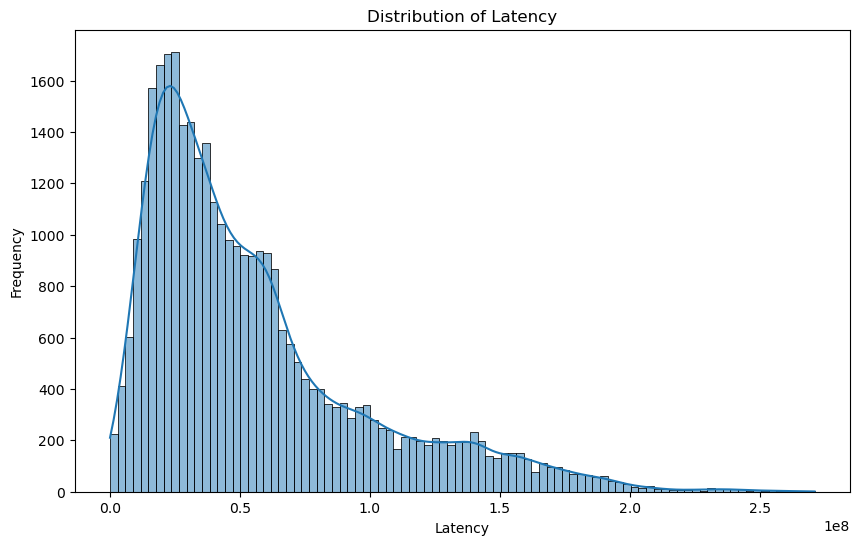

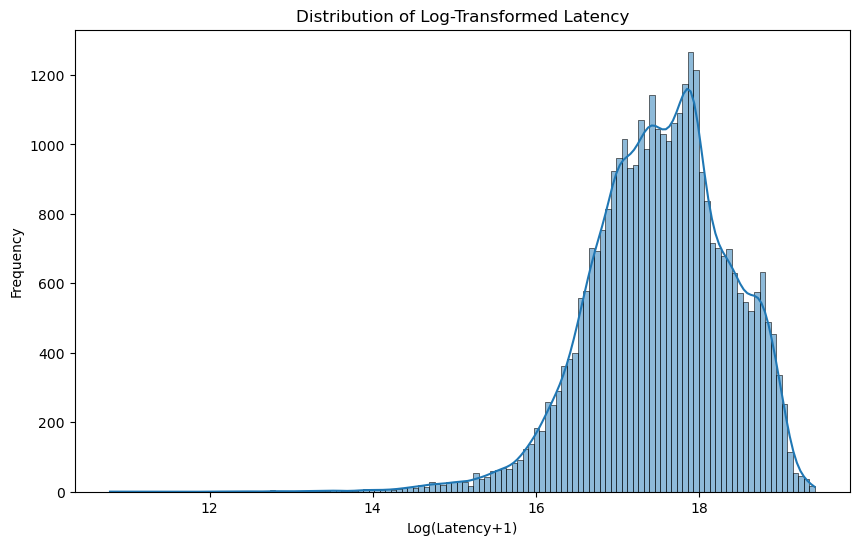

In [8]:
# Check the distribution of the target variable (latency)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['target'], kde=True)
plt.title('Distribution of Latency')
plt.xlabel('Latency')
plt.ylabel('Frequency')
plt.show()

# Check if we need to apply log transformation
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['target']), kde=True)
plt.title('Distribution of Log-Transformed Latency')
plt.xlabel('Log(Latency+1)')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Analyze categorical features
print("Unique values in 'device':\n", train_df['device'].value_counts())
print("\nUnique values in 'area':\n", train_df['area'].value_counts())
print("\nUnique values in 'operator':\n", train_df['operator'].value_counts())

Unique values in 'device':
 device
pc1    19505
pc3    14769
Name: count, dtype: int64

Unique values in 'area':
 area
Park           13438
Residential    10407
Avenue          6889
Highway         3397
Tunnel           143
Name: count, dtype: int64

Unique values in 'operator':
 operator
1    19505
2    14769
Name: count, dtype: int64


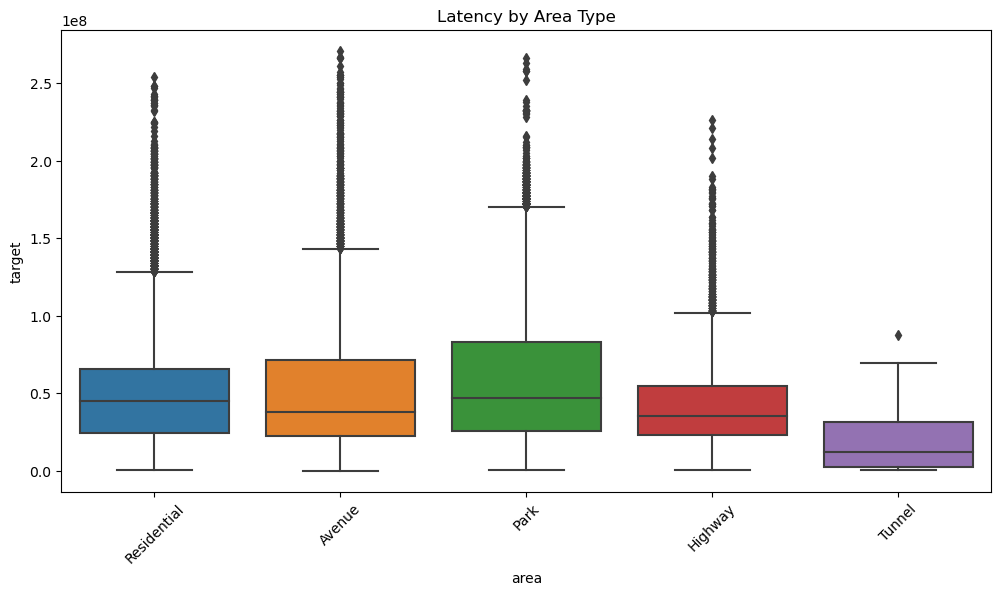

In [10]:
# Plot latency by area type
plt.figure(figsize=(12, 6))
sns.boxplot(x='area', y='target', data=train_df)
plt.title('Latency by Area Type')
plt.xticks(rotation=45)
plt.show()

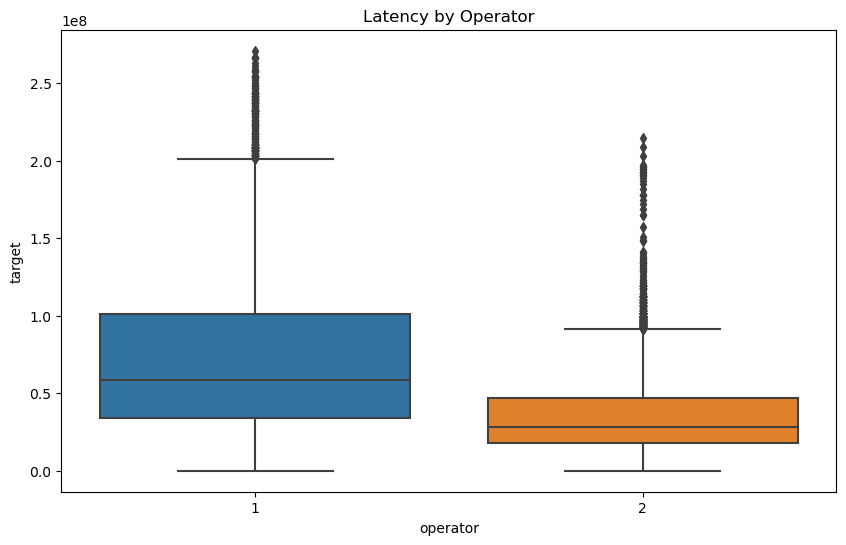

In [11]:
# Plot latency by operator
plt.figure(figsize=(10, 6))
sns.boxplot(x='operator', y='target', data=train_df)
plt.title('Latency by Operator')
plt.show()

In [12]:
# Select key numerical features to analyze correlation with latency
numerical_features = [
    'PCell_RSRP_max', 'PCell_RSRQ_max', 'PCell_RSSI_max', 'PCell_SNR_max',
    'PCell_Downlink_Num_RBs', 'PCell_Downlink_Average_MCS',
    'SCell_RSRP_max', 'SCell_RSRQ_max', 'SCell_RSSI_max', 'SCell_SNR_max',
    'speed_kmh', 'Traffic Jam Factor', 'temperature', 'humidity', 'windSpeed',
    'target'
]

# Calculate correlations with the target
correlations = train_df[numerical_features].corr()['target'].sort_values(ascending=False)
print("Correlations with latency:\n", correlations)

Correlations with latency:
 target                        1.000000
SCell_SNR_max                 0.643400
PCell_SNR_max                 0.578254
PCell_RSSI_max                0.509748
SCell_RSRP_max                0.499241
PCell_RSRP_max                0.476838
SCell_RSSI_max                0.455739
PCell_Downlink_Average_MCS    0.453623
PCell_Downlink_Num_RBs        0.407318
SCell_RSRQ_max                0.290588
humidity                      0.230256
PCell_RSRQ_max                0.199297
Traffic Jam Factor            0.065635
windSpeed                    -0.003589
speed_kmh                    -0.072416
temperature                  -0.248663
Name: target, dtype: float64


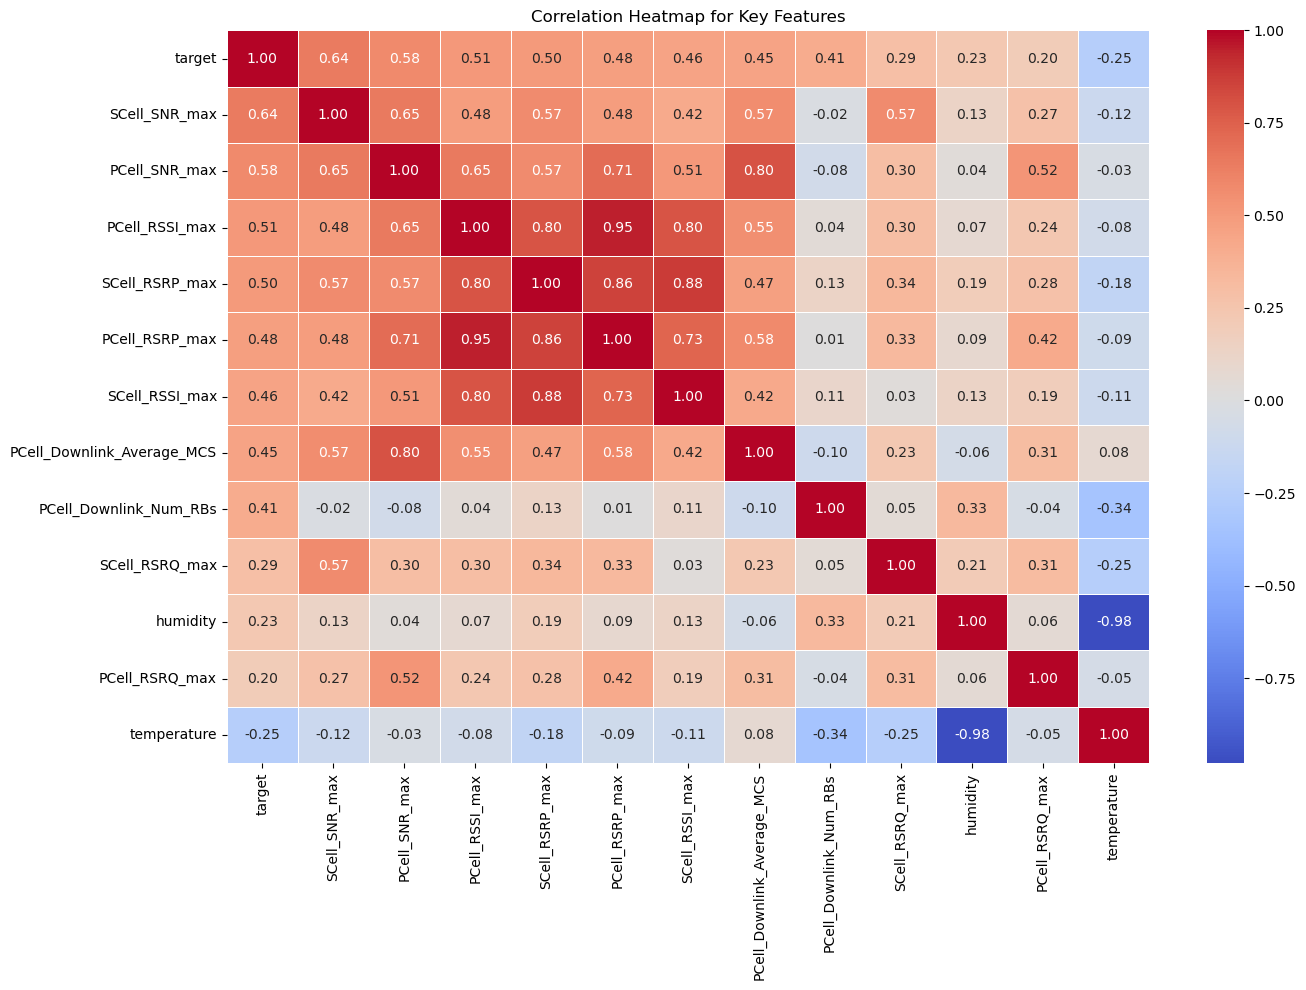

In [13]:
# Plot correlation heatmap for key features
plt.figure(figsize=(14, 10))
key_features = [col for col in correlations.index if abs(correlations[col]) > 0.1][:15]
correlation_matrix = train_df[key_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for Key Features')
plt.tight_layout()
plt.show()

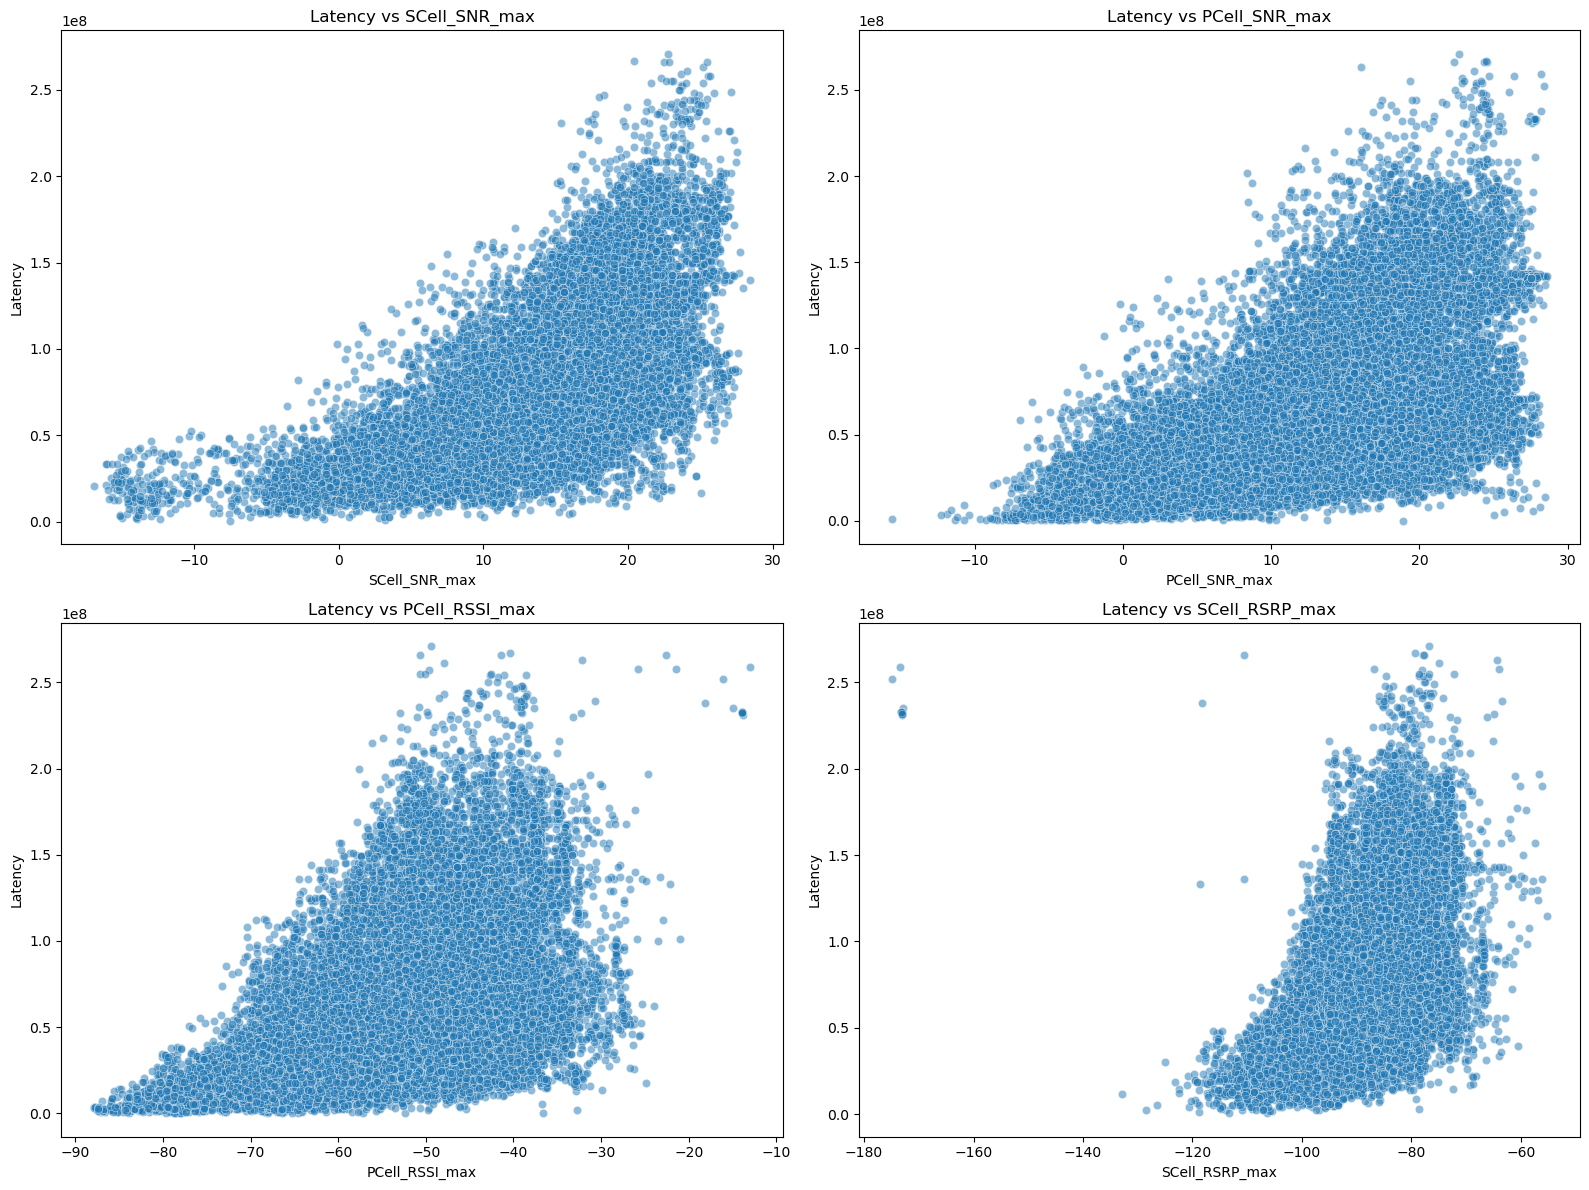

In [14]:
# Scatter plots for top correlated features
top_correlated = [col for col in correlations.index if abs(correlations[col]) > 0.2 and col != 'target'][:4]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(top_correlated):
    sns.scatterplot(x=feature, y='target', data=train_df, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Latency vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Latency')
    
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [15]:
# Make a copy of the data to avoid modifying the original
train_data = train_df.copy()
test_data = test_df.copy()

# Check if the target column exists in the test data
print(f"'target' column in test data: {'target' in test_data.columns}")

'target' column in test data: False


In [16]:
# Separate features and target for the training data
X_train = train_data.drop(['id', 'target'], axis=1)
y_train = train_data['target']

# For test data, we'll just drop the ID column
X_test = test_data.drop(['id'], axis=1)
test_ids = test_data['id']  # Save IDs for submission

In [17]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Number of numerical columns: {len(numerical_cols)}")

Categorical columns: ['device', 'area']
Number of numerical columns: 37


In [18]:
# Create preprocessing pipeline for numerical and categorical features
# For numerical features: impute missing values with median and standardize
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values with most frequent value and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## 4. Feature Engineering

la création de ces nouvelles caractéristiques (feature engineering) est importante car :

Elle capture mieux les relations complexes : La latence dépend de l'interaction de plusieurs facteurs (force du signal, qualité, ressources allouées). Ces nouvelles caractéristiques combinent les mesures brutes pour mieux représenter ces interactions.
Elle améliore la performance du modèle : Les modèles apprennent souvent mieux avec des caractéristiques qui sont plus directement liées à ce que l'on veut prédire (la latence ou le délai des paquets).
Elle intègre la connaissance du domaine : Vous utilisez votre compréhension des réseaux 5G pour créer des indicateurs pertinents (ex: impact combiné de l'environnement, utilisation des ressources).
Elle optimise les données pour le modèle : Certaines transformations (comme log1p) aident le modèle à mieux interpréter les données.
En résumé, cela permet de fournir des informations de meilleure qualité à votre modèle pour qu'il puisse prédire la qualité de service (QoS), et spécifiquement la latence, de manière plus précise.

Pourquoi utilisé log1p:

Gérer les valeurs nulles (zéro)
Réduire l'asymétrie (Skewness)
Stabiliser la variance et Linéariser les relations

En résumé, log1p est un moyen robuste (car il gère les zéros) de transformer des caractéristiques pour les rendre plus adaptées aux modèles d'apprentissage automatique en réduisant leur asymétrie et en stabilisant leur variance.

In [19]:
# Creating derived features for mobile network data
# features relevant to latency

# Function to add network quality features
def add_network_features(df):
    # Create a copy to avoid modifying input
    result = df.copy()
    
    # Signal quality ratio (higher is better)
    result['PCell_Signal_Quality_Ratio'] = result['PCell_RSRP_max'] / (result['PCell_RSRQ_max'].abs() + 1)
    
    # Cell resource utilization
    result['PCell_Resource_Utilization'] = result['PCell_Downlink_Num_RBs'] * result['PCell_Downlink_Average_MCS']
    
    # SNR to MCS ratio (indicates how efficiently the modulation is utilizing the signal quality)
    result['PCell_SNR_MCS_Ratio'] = result['PCell_SNR_max'] / (result['PCell_Downlink_Average_MCS'] + 1)
    
    # For SCell metrics, handle nulls
    has_scell = ~result['SCell_RSRP_max'].isna()
    
    # Signal strength combined (weighted average of PCell and SCell if available)
    result['Combined_Signal_Strength'] = result['PCell_RSRP_max']
    result.loc[has_scell, 'Combined_Signal_Strength'] = (
        0.7 * result.loc[has_scell, 'PCell_RSRP_max'] + 
        0.3 * result.loc[has_scell, 'SCell_RSRP_max']
    )
    
    # Signal quality metric
    result['Signal_Quality_Metric'] = result['PCell_SNR_max'] * result['PCell_RSRP_max'].abs().pow(-0.5)
    
    # Environmental impact factor
    result['Environmental_Impact'] = (
        result['humidity'] * 0.4 + 
        result['windSpeed'] * 0.3 + 
        result['cloudCover'] * 0.3
    )
    
    # Traffic congestion impact
    result['Traffic_Impact'] = np.log1p(result['Traffic Jam Factor'])
    
    # Mobility factor - higher speeds generally increase latency
    result['Mobility_Factor'] = np.log1p(result['speed_kmh'])
    
    return result

# Apply feature engineering
X_train_fe = add_network_features(X_train)
X_test_fe = add_network_features(X_test)

# Show new features
new_features = [col for col in X_train_fe.columns if col not in X_train.columns]
print(f"Created {len(new_features)} new features:")
print(new_features)

# Check correlations of new features with target
correlation_with_target = pd.DataFrame()
for feature in new_features:
    correlation_with_target.loc[feature, 'correlation'] = X_train_fe[feature].fillna(0).corr(y_train)

print("\nCorrelations of new features with latency:")
print(correlation_with_target.sort_values('correlation', ascending=False))

Created 8 new features:
['PCell_Signal_Quality_Ratio', 'PCell_Resource_Utilization', 'PCell_SNR_MCS_Ratio', 'Combined_Signal_Strength', 'Signal_Quality_Metric', 'Environmental_Impact', 'Traffic_Impact', 'Mobility_Factor']

Correlations of new features with latency:
                            correlation
PCell_Resource_Utilization     0.654008
Signal_Quality_Metric          0.583735
PCell_SNR_MCS_Ratio            0.501144
Combined_Signal_Strength       0.461569
PCell_Signal_Quality_Ratio     0.139852
Traffic_Impact                 0.075632
Environmental_Impact           0.044035
Mobility_Factor               -0.103243


In [20]:
# Update column lists after feature engineering
categorical_cols = X_train_fe.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Update the preprocessor with new numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## 5. Model Building and Evaluation

In [21]:
# Split the training data to create a validation set
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_fe, y_train, test_size=0.2, random_state=42
)

Cette fonction sert à entraîner un modèle d'apprentissage automatique et à évaluer sa performance sur des données d'entraînement et de validation.
Voici ce qu'elle fait étape par étape :
model.fit(X_train, y_train) : Entraîne le modèle (model) en utilisant les données d'entraînement (X_train pour les caractéristiques, y_train pour la cible à prédire - la latence/délai).
model.predict(X_train) et model.predict(X_val) : Utilise le modèle entraîné pour faire des prédictions.
y_train_pred : Prédictions sur les données qui ont servi à l'entraînement.
y_val_pred : Prédictions sur de nouvelles données que le modèle n'a pas vues pendant l'entraînement (données de validation, X_val).
Calcul des métriques : Calcule plusieurs indicateurs pour mesurer à quel point les prédictions (y_train_pred, y_val_pred) sont proches des vraies valeurs (y_train, y_val).

Ces métriques sont couramment utilisées pour évaluer les modèles de régression

RMSE (Root Mean Squared Error - Racine de l'erreur quadratique moyenne) :
C'est la racine carrée de la moyenne des erreurs au carré (différence entre la valeur prédite et la vraie valeur).
Pourquoi l'utiliser : Elle pénalise davantage les grosses erreurs (à cause de la mise au carré). Elle est exprimée dans la même unité que votre cible (par exemple, en millisecondes si vous prédisez la latence en ms), ce qui aide à interpréter l'ampleur de l'erreur moyenne. C'est une métrique très standard.


MAE (Mean Absolute Error - Erreur absolue moyenne) :
C'est la moyenne des valeurs absolues des erreurs.
Pourquoi l'utiliser : Elle mesure l'ampleur moyenne des erreurs, sans donner plus de poids aux grosses erreurs qu'aux petites.

R2 Score (Coefficient de détermination) :
Indique la proportion de la variance de la variable cible (latence) qui est expliquée par le modèle. Il varie généralement entre 0 et 1 (mais peut être négatif si le modèle est très mauvais). Un score de 1 signifie que le modèle explique parfaitement la variance ; un score de 0 signifie que le modèle n'est pas meilleur que de simplement prédire la moyenne de la cible.
Pourquoi l'utiliser : Donne une mesure relative de la "qualité" du modèle. Un faible RMSE ou MAE est bien, mais le R2 Score vous dit si c'est bien par rapport à la variabilité naturelle des données. Il aide à comprendre si votre modèle capture bien les variations de la latence.

In [22]:
# Create function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    return {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

In [23]:
# Prepare a list of models to evaluate
models = {
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(n_estimators=100, random_state=42))]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', XGBRegressor(n_estimators=100, random_state=42))]),
}

Pour déterminer le modèle le plus performant, il faut regarder les métriques sur le jeu de validation, car elles indiquent comment le modèle généralise sur de nouvelles données :

Validation RMSE (Root Mean Squared Error) : Plus cette valeur est basse, mieux c'est. Elle représente l'erreur moyenne de prédiction.
Validation R² (R Carré) : Plus cette valeur est proche de 1, mieux c'est. Elle représente la proportion de la variance expliquée par le modèle.



In [24]:
# Evaluate all models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = evaluate_model(model, X_train_split, y_train_split, X_val, y_val)
    print(f"  Validation RMSE: {results[name]['val_rmse']:.2f}")
    print(f"  Validation R²: {results[name]['val_r2']:.4f}")

Training Random Forest...
  Validation RMSE: 10458055.89
  Validation R²: 0.9435
Training XGBoost...
  Validation RMSE: 10433796.07
  Validation R²: 0.9437


In [25]:
# Create a results dataframe for comparison
results_df = pd.DataFrame(results).T
results_df = results_df[['train_rmse', 'val_rmse', 'train_r2', 'val_r2']]
results_df = results_df.sort_values('val_rmse')
results_df

,train_rmse,val_rmse,train_r2,val_r2
XGBoost,6.153927e+06,1.043380e+07,0.979509,0.943732
Random Forest,3.766212e+06,1.045806e+07,0.992325,0.943470


C:\Users\user\AppData\Local\Temp\ipykernel_34460\112548493.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


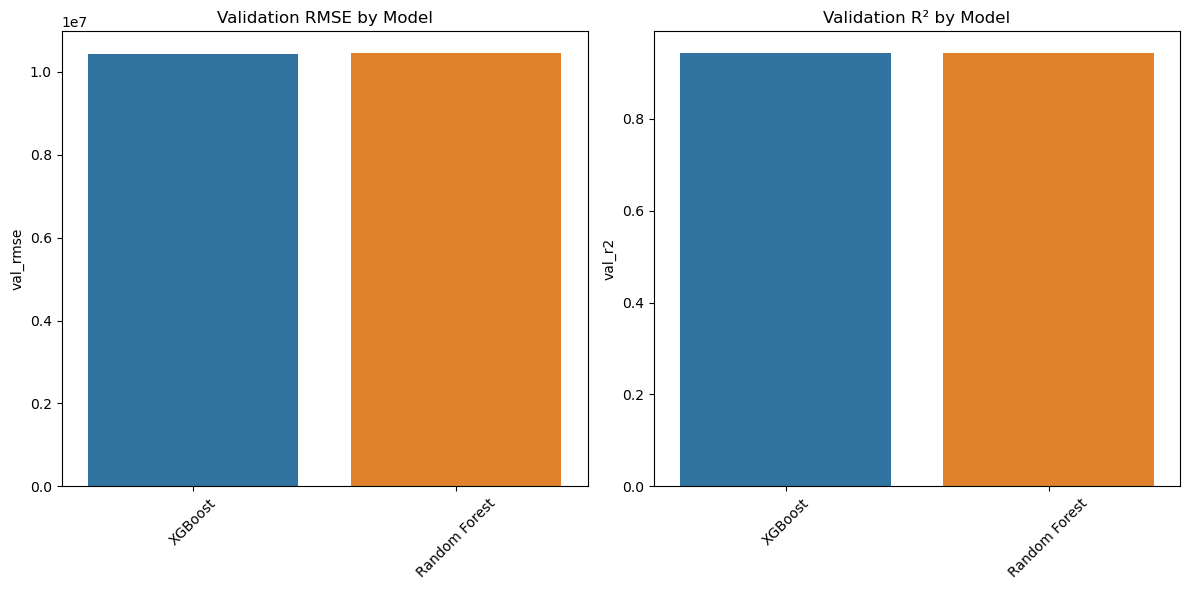

In [26]:
# Plot model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y='val_rmse', data=results_df)
plt.title('Validation RMSE by Model')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y='val_r2', data=results_df)
plt.title('Validation R² by Model')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Conclusion


Le modèle **XGBoost** est le plus performant selon ces résultats. Il a simultanément :

La plus faible RMSE sur le jeu de validation (environ 10,43 Nanosecondes ns équivaut à environ 10.43 millisecondes (ms).).
Le plus haut R² sur le jeu de validation (environ 0.9437).
Les modèles Random Forest est également très performants aussi et très proches de XGBoost.

In [27]:
models

{'Random Forest': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['timestamp',
                                                    'PCell_RSRP_max',
                                                    'PCell_RSRQ_max',
                                                    'PCell_RSSI_max',
                                                    'PCell_SNR_max',
                                                    'PCell_Downlink_Num_RBs',
                                                    'PCell_Downlink_Average_MCS',
                                      

In [28]:
import joblib


In [29]:
# Export du modèle Random Forest
joblib.dump(models['Random Forest'], 'random_forest_pipeline.pkl')

['random_forest_pipeline.pkl']

In [30]:
# Export du modèle XGBoost
joblib.dump(models['XGBoost'], 'xgboost_pipeline.pkl')

['xgboost_pipeline.pkl']